In [27]:
import os
import pickle

import numpy as np
from matplotlib import pyplot as plt

In [28]:
stat_test_name = "test_cifar_random"

stat_tests_path = "stat_tests" 
stat_test_path = os.path.join(stat_tests_path, stat_test_name)
if not os.path.exists(stat_test_path):
    raise FileNotFoundError(f"Stat test path {stat_test_path} does not exist.")

init_params_path = os.path.join(stat_test_path, "init_params.pkl")
test_params_path = os.path.join(stat_test_path, "test_params.pkl")

with open(init_params_path, "rb") as f:
    init_params = pickle.load(f)
with open(test_params_path, "rb") as f:
    test_params = pickle.load(f)


print("Init params:")
for k, v in init_params.items():
    print(f"{k}: {v}")

num_tests = init_params["num_tests"] 
num_tests = 10

tests_results = []  # 2-dim list [idx of repeated test][idx of test]
for i in range(num_tests):
    test_path = os.path.join(stat_test_path, f"test_{i}")
    test_result_path = os.path.join(test_path, "test_results.pkl")
    
    with open(test_result_path, "rb") as f:

        test_result = pickle.load(f)
    tests_results.append(test_result)

Init params:
test_name: test_cifar_random
dataset_name: cifar10
num_clients: 5
num_classes: 10
distribution_type: random
model_name: resnet18
loss_name: cross_entropy
trainer_name: sgd
train_epochs: 40
target_client: 0
num_tests: 20


In [29]:
for i in range(num_tests):
    for j in range(len(tests_results[i])):
        tests_results[i][j]['trained_target_accuracy'] = tests_results[i][j]['trained_clients_accuracies'][init_params['target_client']]
        tests_results[i][j]['benchmark_target_accuracy'] = tests_results[i][j]['benchmark_clients_accuracies'][init_params['target_client']]
        tests_results[i][j]['reset_target_accuracy'] = tests_results[i][j]['reset_clients_accuracies'][init_params['target_client']]
        tests_results[i][j]['retrained_target_accuracy'] = tests_results[i][j]['retrained_clients_accuracies'][init_params['target_client']]

for i in range(num_tests):
    for j in range(len(tests_results[i])):
        tests_results[i][j]['trained_target_accuracy'] = tests_results[i][j]['trained_class_accuracies'][init_params['target_client']+init_params['num_clients']]
        tests_results[i][j]['benchmark_target_accuracy'] = tests_results[i][j]['benchmark_class_accuracies'][init_params['target_client']+init_params['num_clients']]
        tests_results[i][j]['reset_target_accuracy'] = tests_results[i][j]['reset_class_accuracies'][init_params['target_client']+init_params['num_clients']]
        tests_results[i][j]['retrained_target_accuracy'] = tests_results[i][j]['retrained_class_accuracies'][init_params['target_client']+init_params['num_clients']]

In [38]:
subtest = 1

subtest_params = []
subtest_results = []    # 2-dim list [idx of test][idx of repeated test]
for i, test_param in enumerate(test_params):
    if test_param["subtest"] == subtest:
        subtest_params.append(test_param)
        subtest_results.append([])
        for j in range(num_tests):
            subtest_results[-1].append(tests_results[j][i])

print("Subtest params:")
for key, value in subtest_params[0].items():
    if key == "unlearning_percentage":
        continue
    print(f"{key}: {value}")

print(f"\nAvailable results:")
for key in subtest_results[0][0].keys():
    print(key)

percentages = []
for test_param in subtest_params:
    percentages.append(int(test_param["unlearning_percentage"]))

print(f"\nUnlearning percentages: {percentages}")

Subtest params:
subtest: 1
unlearning_method: parameters
tests: ['test_accuracy', 'clients_accuracies', 'mia']
mia_classifier_types: ['nn', 'logistic']
retrain_epochs: 1

Available results:
total_individual_reset_params
trained_test_accuracy
benchmark_test_accuracy
reset_test_accuracy
retrained_test_accuracy
trained_clients_accuracies
benchmark_clients_accuracies
reset_clients_accuracies
retrained_clients_accuracies
trained_mia_nn
benchmark_mia_nn
reset_mia_nn
retrained_mia_nn
trained_mia_logistic
benchmark_mia_logistic
reset_mia_logistic
retrained_mia_logistic
trained_target_accuracy
benchmark_target_accuracy
reset_target_accuracy
retrained_target_accuracy

Unlearning percentages: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


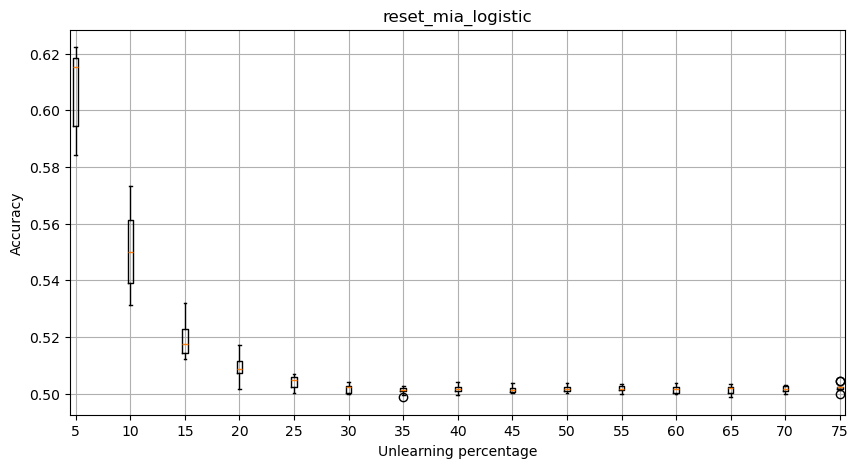

In [ ]:
key = "reset_mia_logistic"
tests_accuracies = []
for results in subtest_results:
    test_accuracies = [results[i][key]["roc_auc"] for i in range(num_tests)]
    tests_accuracies.append(test_accuracies)

# Test accuracies plot
plt.figure(figsize=(10, 5))
plt.boxplot(tests_accuracies, positions=percentages)
plt.title(key)
plt.xlabel("Unlearning percentage")
plt.ylabel("Accuracy")
plt.xticks(percentages)
plt.grid()

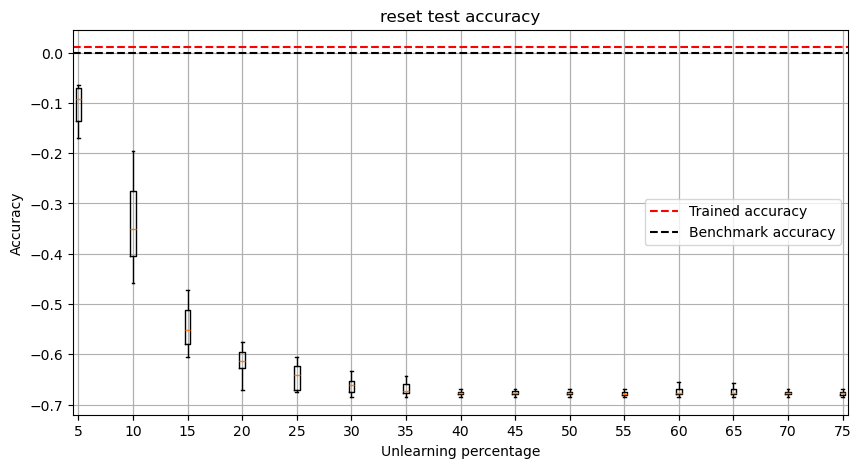

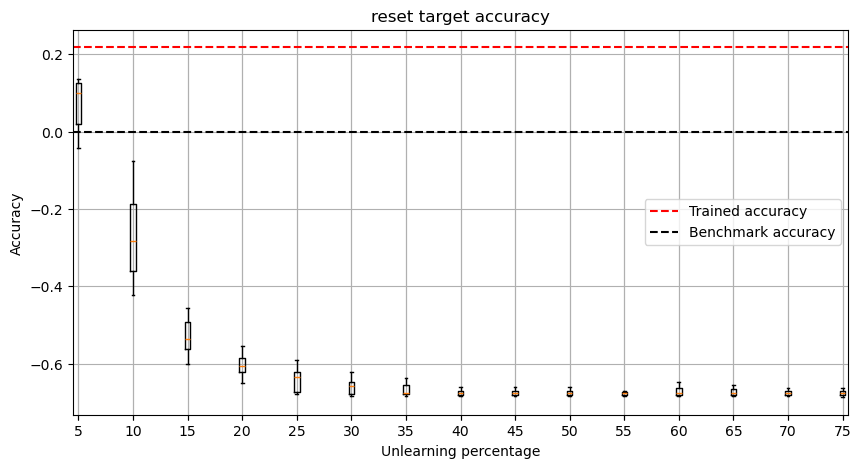

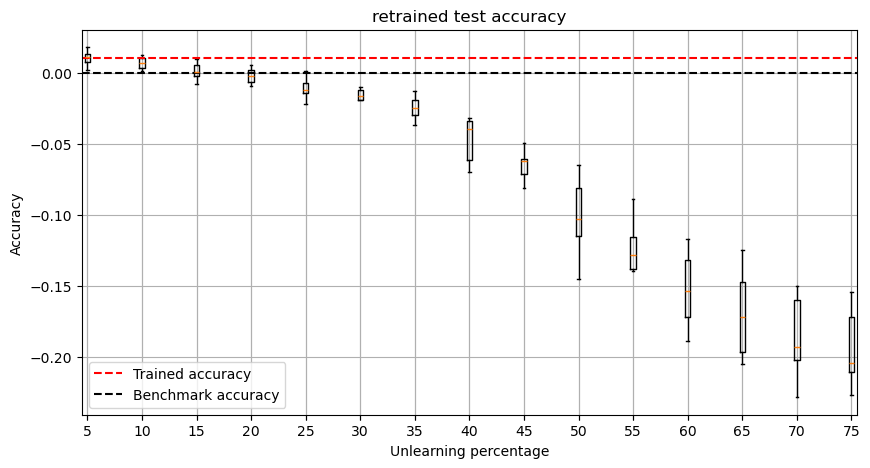

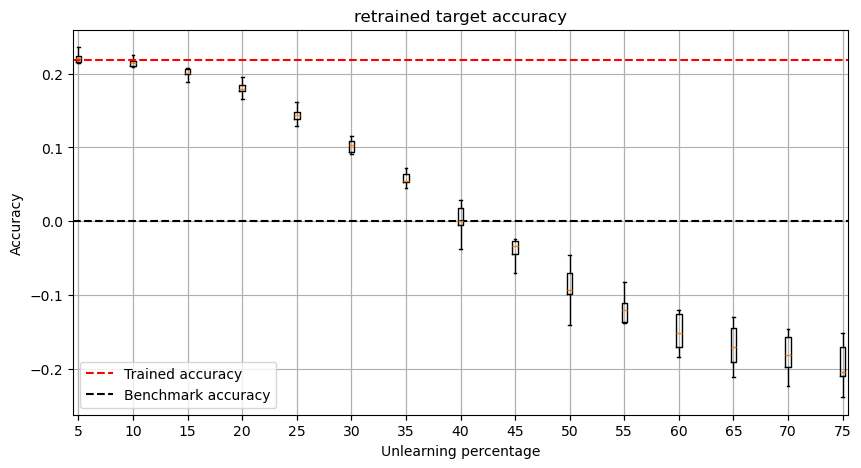

In [ ]:
lines = ["reset", "retrained"]

for j, model in enumerate(lines):
    plt.figure(j, figsize=(10, 5))
    plt.title(f"{model} test accuracy")
    plt.xlabel("Unlearning percentage")
    plt.ylabel("Accuracy")
    plt.xticks(percentages)
    plt.grid()

    plt.figure(len(lines) + j, figsize=(10, 5))
    plt.title(f"{model} target accuracy")
    plt.xlabel("Unlearning percentage")
    plt.ylabel("Accuracy")
    plt.xticks(percentages)
    plt.grid()
    
    delta_trained_accuracy = results[0][f"trained_test_accuracy"] - results[0]["benchmark_test_accuracy"]
    delta_target_accuracy = results[0][f"trained_target_accuracy"] - results[0]["benchmark_target_accuracy"]

    delta_test_accuracies = []
    delta_target_accuracies = []
    for i in range(len(percentages)):
        results = subtest_results[i]
        benchmark_test_accuracies = [results[i]["benchmark_test_accuracy"] for i in range(num_tests)]
        benchmark_target_accuracies = [results[i]["benchmark_target_accuracy"] for i in range(num_tests)]
        model_test_accuracies = [results[i][f"{model}_test_accuracy"] for i in range(num_tests)]
        model_target_accuracies = [results[i][f"{model}_target_accuracy"] for i in range(num_tests)]
        delta_test_accuracies.append([model_test_accuracies[i] - benchmark_test_accuracies[i] for i in range(num_tests)])
        delta_target_accuracies.append([model_target_accuracies[i] - benchmark_target_accuracies[i] for i in range(num_tests)])
    
    plt.figure(j)
    plt.boxplot(delta_test_accuracies, positions=percentages, widths=0.5, showfliers=False)
    plt.axhline(y=delta_trained_accuracy, color='r', linestyle='--', label="Trained accuracy")
    plt.axhline(y=0, color='k', linestyle='--', label="Benchmark accuracy")
    plt.legend()

    plt.figure(len(lines) + j)
    plt.boxplot(delta_target_accuracies, positions=percentages, widths=0.5, showfliers=False)
    plt.axhline(y=delta_target_accuracy, color='r', linestyle='--', label="Trained accuracy")
    plt.axhline(y=0, color='k', linestyle='--', label="Benchmark accuracy")
    plt.legend()


    

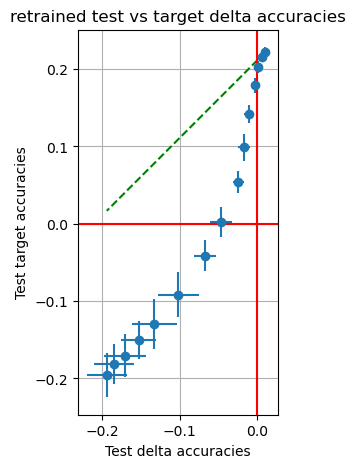

In [ ]:
model = "retrained"

plt.figure(figsize=(10, 5))
plt.title(f"{model} test vs target delta accuracies")
plt.xlabel("Test delta accuracies")
plt.ylabel("Test target accuracies")
plt.grid()

delta_test_accuracies = []
delta_target_accuracies = []
for i in range(len(percentages)):
    results = subtest_results[i]
    benchmark_test_accuracies = [results[i]["benchmark_test_accuracy"] for i in range(num_tests)]
    benchmark_target_accuracies = [results[i]["benchmark_target_accuracy"] for i in range(num_tests)]
    model_test_accuracies = [results[i][f"{model}_test_accuracy"] for i in range(num_tests)]
    model_target_accuracies = [results[i][f"{model}_target_accuracy"] for i in range(num_tests)]
    delta_test_accuracies.append([model_test_accuracies[i] - benchmark_test_accuracies[i] for i in range(num_tests)])
    delta_target_accuracies.append([model_target_accuracies[i] - benchmark_target_accuracies[i] for i in range(num_tests)])

delta_test_accuracies_avg = [np.mean(delta_test_accuracies[i]) for i in range(len(delta_test_accuracies))]
delta_test_accuracies_std = [np.std(delta_test_accuracies[i]) for i in range(len(delta_test_accuracies))]
delta_target_accuracies_avg = [np.mean(delta_target_accuracies[i]) for i in range(len(delta_target_accuracies))]
delta_target_accuracies_std = [np.std(delta_target_accuracies[i]) for i in range(len(delta_target_accuracies))]

plt.errorbar(delta_test_accuracies_avg, delta_target_accuracies_avg, xerr=delta_test_accuracies_std, yerr=delta_target_accuracies_std, fmt='o')

x_variation = delta_test_accuracies_avg[0] - delta_test_accuracies_avg[-1]
xs = [delta_test_accuracies_avg[0], delta_test_accuracies_avg[-1]]
ys = [delta_target_accuracies_avg[0], delta_target_accuracies_avg[0] - x_variation]
plt.gca().set_aspect('equal')
plt.plot(xs, ys, color='g', linestyle='--', )
plt.axhline(0, color='r', linestyle='-')
plt.axvline(0, color='r', linestyle='-')



    